# Baidu Traffic speed prediction

This notebook is training part description of "[Baidu Traffic Speed Prediction](https://ai.baidu.com/broad/subordinate?dataset=traffic)"

A random mechanism is used in this implementation, program will choose Model from **self-attention**, **GRU**, **1-5 hidden layers Dense net**, also random choose **hyper parameters** and random choose **data features** to train.

Further idea is using nerual arhitecture search to do model evolution.

# Requirement
- python 3.4+
- pytorch 0.4.1+
- tqdm
- numpy


# Usage

### 0) Download the data.

Download data in this [link]( https://ai.baidu.com/broad/download?dataset=traffic)

In this notebook only use `traffic_speed_sub-dataset.zip` and `road_network_sub-dataset.zip` packages.

### 1) Preprocess the data.
Create data folder, and unzip upper two packages to it
```bash
mkdir data
unzip traffic_speed_sub-dataset.zip -d ./data
unzip road_network_sub-dataset.zip -d ./data
```
create clean folder
```bash
mkdir clean
```

run data processing scripts

```bash
python 01_trafficDataRaw.py
python 02_extract_link_id_dict.py
python 03_geoInfo.py
python 04_timeInformation.py
python 05_perpare_train_data.py
```
dataset is splited into first half and second half, this notebook will only use first half to train and validation.

### 2) Randomly choose models and features and train
Example:
```bash
python autoML.py SimpleFC 1      # choose SimpleFC model and try once.
python autoML.py SimpleFC3 5     # choose SimpleFC3 model and try 5 times.
python autoML.py Transformer 1    # choose Transfomer model and try once.
python autoML.py GRU 1           # choose GRU model and try once.
```
> currently support model including: SimpleFC(1 hidden layer Dense net), SimpleFC2(2 hidden layer Dense net) ... to SimpleFC5(5 hidden layer Dense net), SimpleFC5_block(residential 9 hidden layer Dense net.), Transformer(multi head self-attention), GRU.


### 3) View result
step 2 will generate one folder for each try, run vi



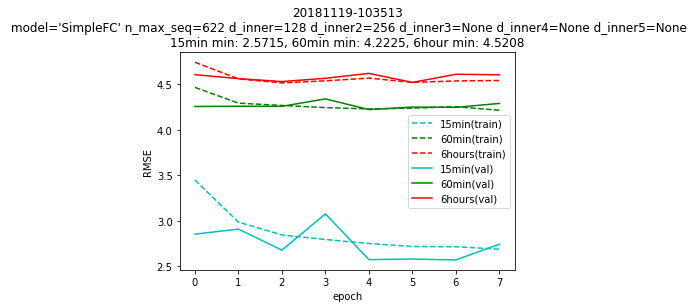

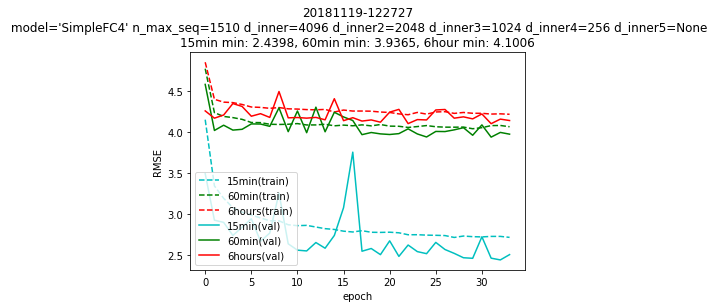

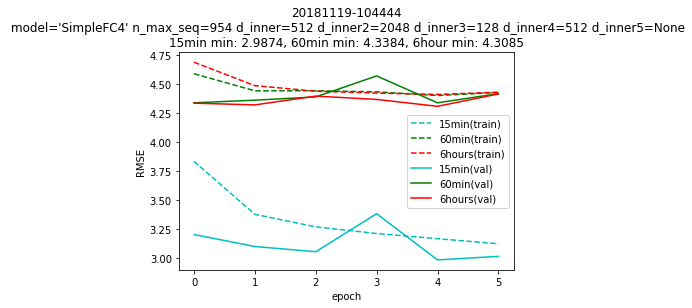

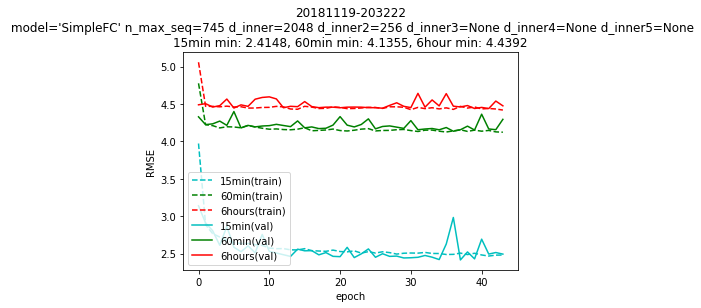

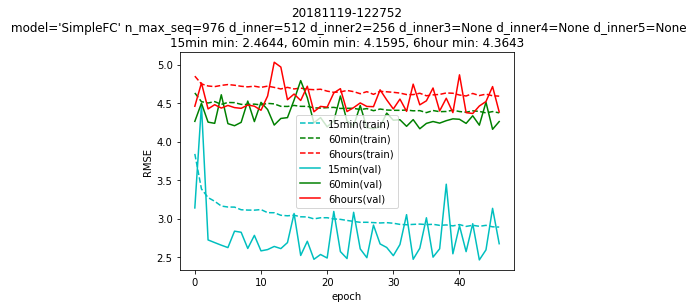

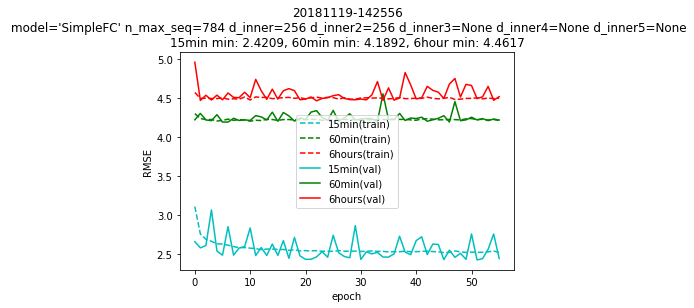

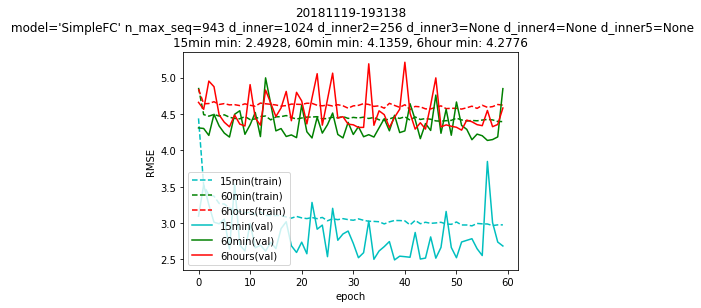

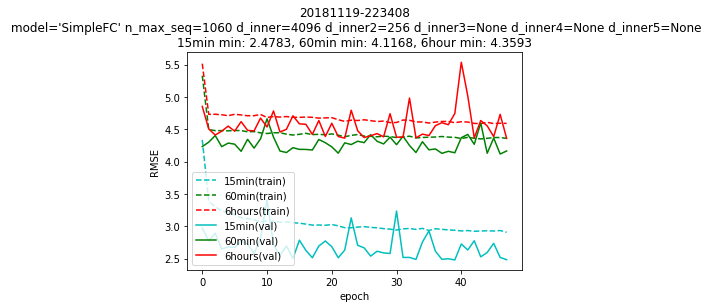

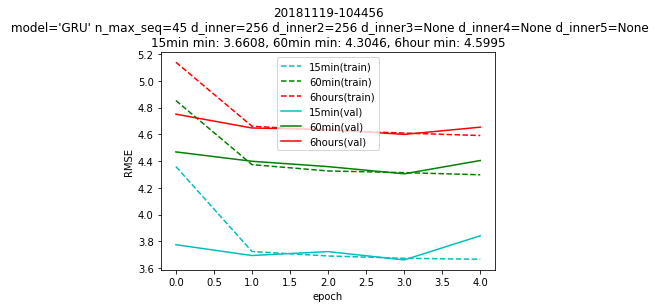

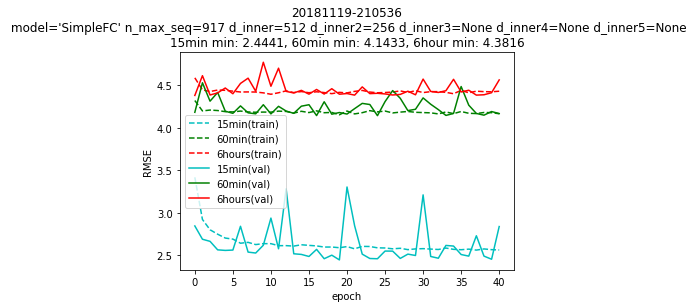

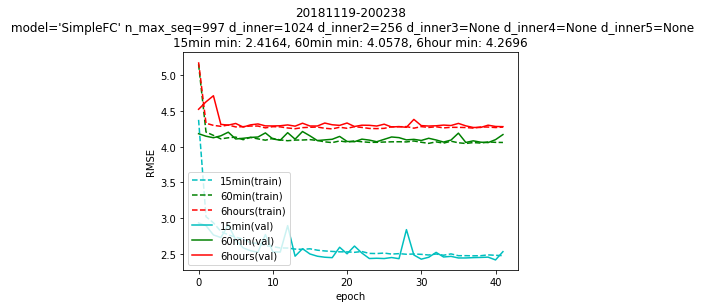

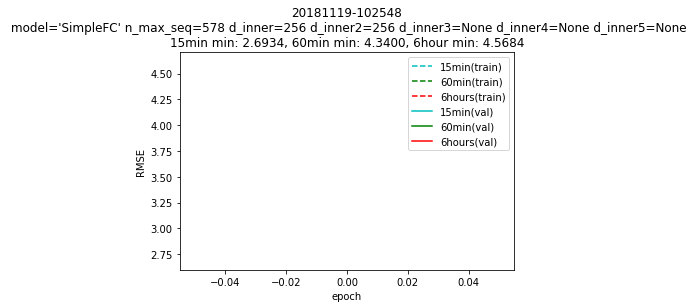

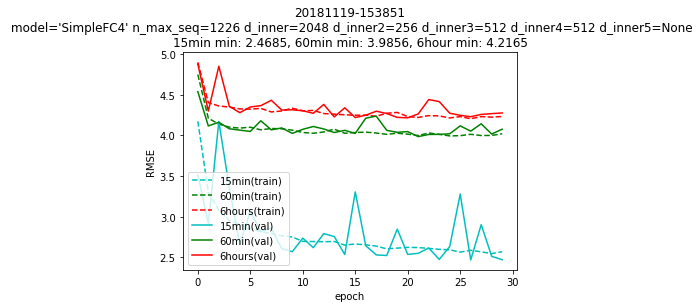

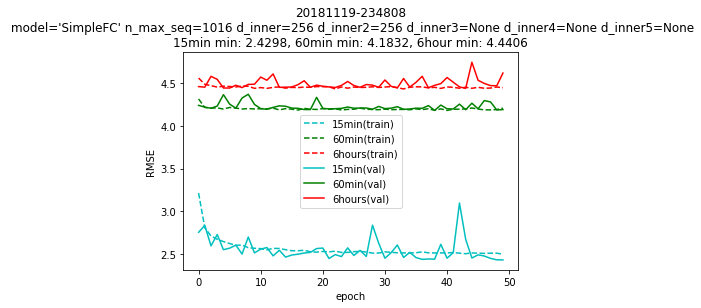

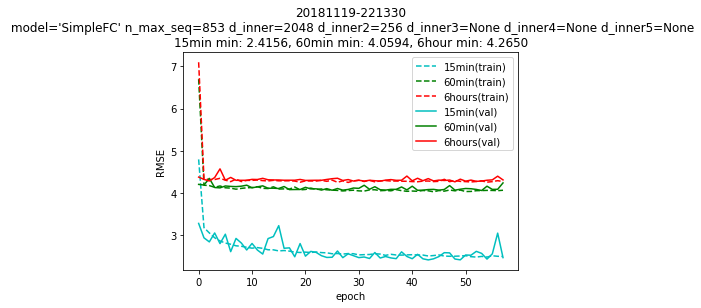

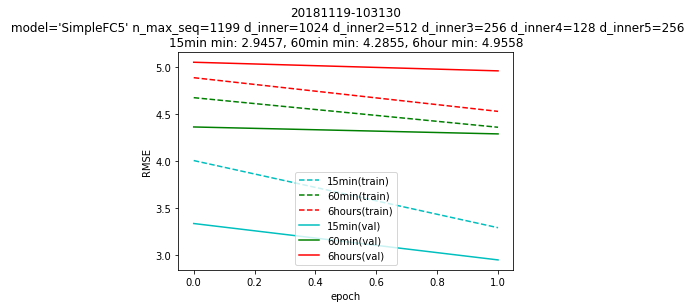

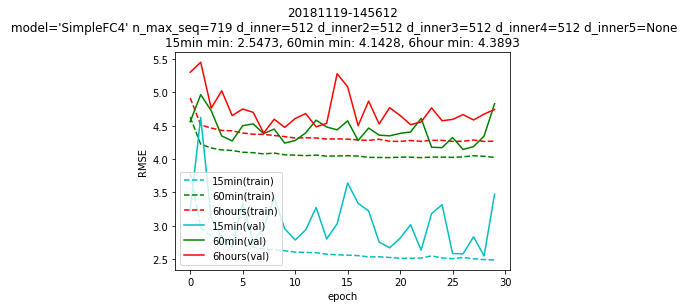

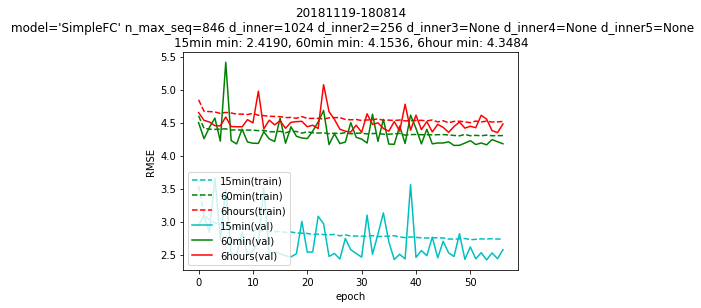

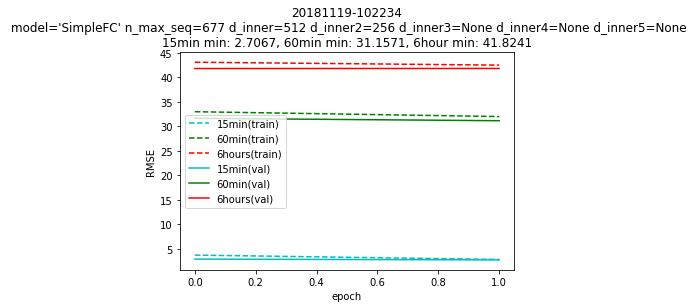

In [1]:
import os.path
import glob
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

folder_list=[]
acc_list=[]
hyper_list=[]

headers=['epoch','loss','15min(train)', '60min(train)', '6hours(train)','15min acc', '60min acc', '6hours acc']
vheaders=['vepoch','vloss','15min(val)', '60min(val)', '6hours(val)','15min vacc', '60min vacc', '6hours vacc']

for folder in glob.glob("20181119*"):
    if not os.path.isfile(folder.strip()+'/train.log'):
        continue
        
    folder_list.append(folder)
    train=pd.read_csv(folder.strip()+'/train.log', names=headers)
    val=pd.read_csv(folder.strip()+'/valid.log', names=vheaders)
    x=pd.concat([train,val],axis=1)
    acc_list.append(x)
    hypers=open(folder.strip()+'/hyperpara.txt').read()[10:-1].split(',')
    model=[[x for x in  hypers if 'model' in x][1]]+\
                [x for x in  hypers if 'n_max_seq' in x]+\
                [x for x in  hypers if 'd_inner=' in x]+\
                [x for x in  hypers if 'd_inner2=' in x]+\
                [x for x in  hypers if 'd_inner3=' in x]+\
                [x for x in  hypers if 'd_inner4=' in x]+\
                [x for x in  hypers if 'd_inner5=' in x]
    hyper_list.append(model)
    
for i in range(len(folder_list)):
    df=acc_list[i][['15min(train)', '60min(train)', '6hours(train)','15min(val)', '60min(val)', '6hours(val)']]
    model=''.join(hyper_list[i])+'\n'
    desc='15min min: %2.4f, 60min min: %2.4f, 6hour min: %2.4f'%(df['15min(val)'].min(),df['60min(val)'].min(),df['6hours(val)'].min())
    ax=df.plot(style=['c--','g--','r--','c-','g-','r-'],title=folder_list[i]+'\n'+model+desc)
    ax.set_xlabel("epoch")
    ax.set_ylabel("RMSE")